# DCA for monocyte

In [1]:
#Note that, this file is runned under `cardec` environment
"""Broadly useful python packages"""
import pandas as pd
import os
import sys
import numpy as np
import pickle
from copy import deepcopy
from shutil import move
import warnings
import keras 
import tensorflow as tf

"""Machine learning and single cell packages"""
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc

import anndata
from anndata import AnnData
import platform
#from tensorflow.keras.utils import plot_model
#import dca
import dca
from dca.api import dca as dca_api
import scanpy as sc
import scanpy.external as sce
"""Read and normalize the data"""

Using TensorFlow backend.
/home/xiaoxiang/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/xiaoxiang/.local/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


'Read and normalize the data'

In [2]:
print("The version of scanpy is:",sc.__version__)
print("The version of keras is:",keras.__version__)
print("The version of anndata is:",anndata.__version__)
print("The version of tensorflow is",tf.__version__)
#print("The version of dca is",dca.__version__)

The version of scanpy is: 1.6.0
The version of keras is: 2.3.1
The version of anndata is: 0.7.4
The version of tensorflow is 1.15.0


In [3]:
adata = sc.read("../../raw_data/monocyte_desc_use.h5ad", cache=True)
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=30) # must filter that genes with all zeros
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata.obs['BatchID'] = adata.obs['dataset_batch'].copy()
adata
#adata.write("dca_test.h5ad")


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 10878 × 11160
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID'
    var: 'genename', 'n_cells'

In [4]:
#normalize function in dca
def dca_normalize(adata,filter_min_counts=True,normalize_input=True, logtrans_input=True,size_factors=True):
    adata=adata.copy()
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)
    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
            
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

In [5]:
#create output dir
build_dir("dca Results/ALL")

# 1. dca Model using all genes
## 1.1 Using the denoised values by dca

In [6]:
#use mode="latent" and predict denoised by returned network `net`
adata_ae,net=dca_api(adata.copy(),mode="latent",ae_type  = 'nb-conddisp',
    normalize_per_cell= True,
    #epochs=300,
    threads=4,
    #batch_size=256,
    scale = True,
    log1p = True,
    #hidden_size =  (128, 32, 128),
    copy=True,
    return_info=True,
    return_model=True)
#X_dca has been saved in X_obsm
adata_ae.raw=adata_ae

# save net
net.model.save("./dca Results/ALL/net.model.h5")
net.model.save_weights("./dca Results/ALL/net.model.weights.h5")
net.encoder.save("./dca Results/ALL/net.encoder.h5")
net.encoder.save_weights("./dca Results/ALL/net.encoder.weights.h5")
for i in net.extra_models.keys():
    net.extra_models[i].save("./dca Results/ALL/"+str(i)+".h5")
    net.extra_models[i].save_weights("./dca Results/ALL/"+str(i)+"_weights.h5")

2021-02-25 11:21:20,699 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/api.py:149: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



dca: Successfully preprocessed 11160 genes and 10878 cells.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-02-25 11:21:21,771 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-02-25 11:21:21,969 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/train.py:41: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2021-02-25 11:21:21,970 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/train.py:41: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2021-02-25 11:21:22,007 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/loss.py:87: The name tf.lgamma is deprecated. Please use tf.math.lgamma instead.



2021-02-25 11:21:22,014 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/loss.py:88: The name tf.log is deprecated. Please use tf.math.log instead.



2021-02-25 11:21:22,023 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/loss.py:10: The name tf.is_nan is deprecated. Please use tf.math.is_nan instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2021-02-25 11:21:22,025 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/dca/loss.py:10: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2021-02-25 11:21:23,380 [WARNING] From /home/xiaoxiang/anaconda3/envs/tfv1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



dca: Calculating low dimensional representations...


In [7]:
#predicted normalized
adata_tmp = dca_normalize(adata.copy(),size_factors=True)#get the input for dca
x_hat=net.model.predict({'count': adata_tmp.X,
                                          'size_factors': adata_tmp.obs.size_factors})
del adata_tmp

/home/xiaoxiang/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


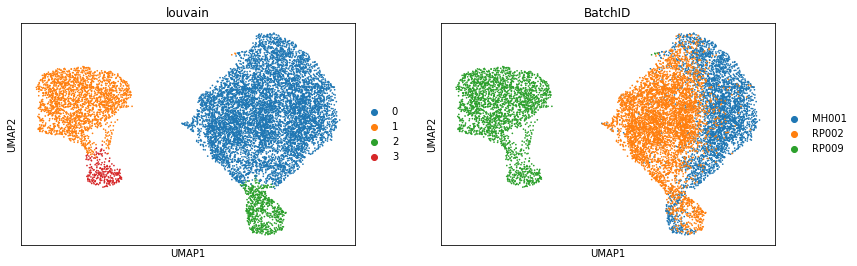

In [8]:
adata_ae.X=x_hat.copy()
sc.pp.normalize_per_cell(adata_ae)# the default dca normalizes data by normalize_per_cell func but no normalize_total
sc.pp.log1p(adata_ae)
sc.pp.highly_variable_genes(adata_ae, inplace = True, min_mean = 0.0125, max_mean = 3, min_disp = 0.5, 
                                          n_bins = 20, n_top_genes = 2000, batch_key = "BatchID",subset=True)
sc.pp.scale(adata_ae)
sc.pp.pca(adata_ae)
sc.pp.neighbors(adata_ae,n_neighbors = 15)
sc.tl.umap(adata_ae)
#sc.tl.louvain(adata_ae, resolution=0.2)
res = find_resolution(adata_ae, 4)
sc.tl.louvain(adata_ae, resolution = res)
sc.pl.umap(adata_ae, color = ["louvain", "BatchID"], show=True)

In [9]:
dca_adata=sc.AnnData(x_hat.copy(),obs=adata.obs.copy(),var=adata.var.copy())# .X is the denoised values
dca_adata.obsm['X_umap_denoised']=adata_ae.obsm['X_umap'].copy()
dca_adata.obsm['X_pca_denoised']=adata_ae.obsm['X_pca'].copy()
dca_adata.obs['louvain_denoised']=adata_ae.obs['louvain'].copy()

## 1.2 Using the latent embedding  by dca

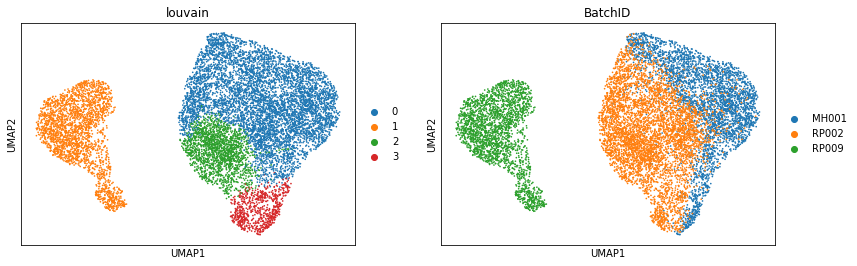

In [10]:
sc.pp.neighbors(adata_ae, use_rep="X_dca",n_neighbors = 15)
sc.tl.umap(adata_ae)
#sc.tl.louvain(adata_ae, resolution=0.2)
res = find_resolution(adata_ae, 4)
sc.tl.louvain(adata_ae, resolution = res)
sc.pl.umap(adata_ae, color = ["louvain", "BatchID"], show=True)

In [11]:
dca_adata.obsm['X_umap_latent']=adata_ae.obsm['X_umap'].copy()
dca_adata.obsm['X_dca_latent']=adata_ae.obsm['X_dca'].copy()
dca_adata.obs['louvain_latent']=adata_ae.obs['louvain'].copy()

In [12]:
dca_adata.write("dca Results New/adata_all.h5ad")

In [30]:
dca_adata=sc.read("dca Results/adata_all.h5ad")

In [31]:
dca_adata

AnnData object with n_obs × n_vars = 10878 × 11160
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID', 'louvain_denoised', 'louvain_latent'
    var: 'genename', 'n_cells'
    obsm: 'X_dca_latent', 'X_pca_denoised', 'X_umap_denoised', 'X_umap_latent'

In [32]:
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X=dca_adata.X, var=dca_adata.var, obs = dca_adata.obs)
# first store the raw data 
adata_combat.raw = adata_combat.copy()
sc.pp.normalize_total(adata_combat)
sc.pp.log1p(adata_combat)
# run combat
sc.pp.combat(adata_combat, key='BatchID')

tmp = AnnData(dca_adata.obsm['X_dca_latent'],obs=dca_adata.obs)
adata_combat.obsm['X_dca_latent'] = sc.pp.combat(tmp, key = 'BatchID', inplace = False)
adata_combat_ori=adata_combat.copy()

In [33]:
#sc.pp.highly_variable_genes(adata_combat)
#print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
#sc.pl.highly_variable_genes(adata_combat)

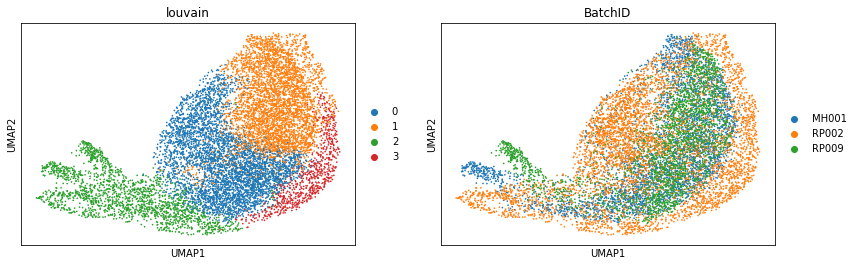

In [34]:
#latent
sc.pp.neighbors(adata_combat, n_neighbors = 15, use_rep = 'X_dca_latent')
sc.tl.umap(adata_combat)
res = find_resolution(adata_combat, 4)
adata_combat = sc.tl.louvain(adata_combat, resolution = res, copy = True)
sc.pl.umap(adata_combat, color = ["louvain", "BatchID"], show=True)

In [35]:
hvg_genes_df=pd.read_csv("/home/xiaoxiang/Documents/carDEC_paper/CarDEC_new20200421/final_processed_results/CarDEC_hvg_used.tsv",sep="\t")
#top 2000 genes 
hvg_genes_df=hvg_genes_df[hvg_genes_df["Variance Type"]=="HVG"]
hvg_genes=list(hvg_genes_df['genename'].values)

In [36]:
tmp = sc.AnnData(X=adata_combat.X, var=adata_combat.var, obs = adata_combat.obs)
tmp=tmp[:,tmp.var.genename.isin(hvg_genes)]
sc.pp.scale(tmp)
sc.pp.pca(tmp,n_comps=32,svd_solver='arpack')
adata_combat_ori.obsm["X_pcahvg"]=tmp.obsm['X_pca'].copy()
sc.pp.neighbors(tmp, n_pcs =32,n_neighbors = 15)
sc.tl.umap(tmp)
#sc.tl.tsne(adata_combat, n_pcs = 32)

/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


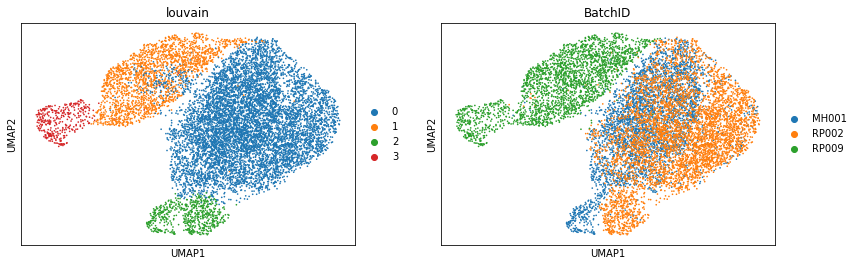

In [37]:
#sc.tl.louvain(adata_ae, resolution=0.2)
res = find_resolution(tmp, 4)
sc.tl.louvain(tmp,resolution = res)
sc.pl.umap(tmp, color = ["louvain", "BatchID"], show=True)

In [38]:
tmp = sc.AnnData(X=adata_combat.X, var=adata_combat.var, obs = adata_combat.obs)
sc.pp.scale(tmp)
sc.pp.pca(tmp,n_comps=32,svd_solver='arpack')
adata_combat_ori.obsm["X_pcaall"]=tmp.obsm['X_pca'].copy()
sc.pp.neighbors(tmp, n_pcs =32,n_neighbors = 15)
sc.tl.umap(tmp)
#sc.tl.tsne(adata_combat, n_pcs = 32)

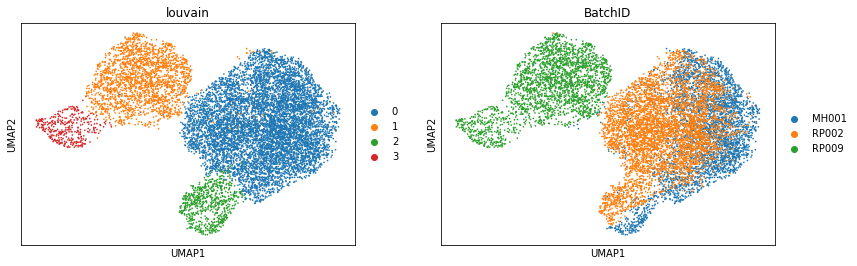

In [39]:
#sc.tl.louvain(adata_ae, resolution=0.2)
res = find_resolution(tmp, 4)
sc.tl.louvain(tmp,resolution = res)
sc.pl.umap(tmp, color = ["louvain", "BatchID"],show=True)

In [40]:
adata_combat_ori.write("dca Results New/adata_all.h5ad")
del adata_combat_ori